In [114]:
from azure.cognitiveservices.vision.face import FaceClient
from azure.cognitiveservices.vision.face.models import TrainingStatusType
from msrest.authentication import CognitiveServicesCredentials
from azure.identity import DefaultAzureCredential
from azure.keyvault.secrets import SecretClient
import glob
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
import uuid
import time, os
from azure.storage.blob import BlobServiceClient

## Azure authentication
Because of a technical problem (Face API not available for private users??) I need to use the lab environment for this step.

In [115]:
FACE_KEY = "aa04c259b56b41b5ad75c24fb515d9f4"
FACE_ENDPOINT = "https://cvprojectface.cognitiveservices.azure.com/"

In [116]:
# Create a client
face_client = FaceClient(FACE_ENDPOINT, CognitiveServicesCredentials(FACE_KEY))

In [117]:
face_client.api_version

'1.0'

# Load face images from local files

In [118]:
my_face_images = [file for file in glob.glob('./thumbnails/*.jpg')]
print(my_face_images)

['./thumbnails\\human-face1.jpg', './thumbnails\\human-face2.jpg', './thumbnails\\human-face3.jpg', './thumbnails\\human-face4.jpg', './thumbnails\\human-face5.jpg', './thumbnails\\human-face6.jpg', './thumbnails\\human-face7.jpg', './thumbnails\\human-face8.jpg']


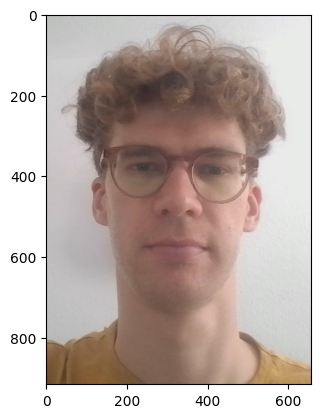

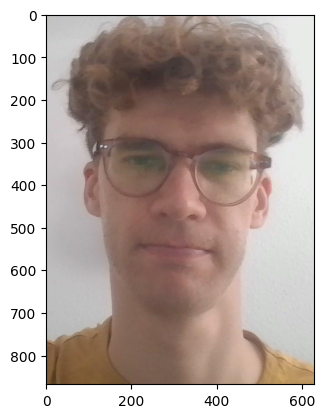

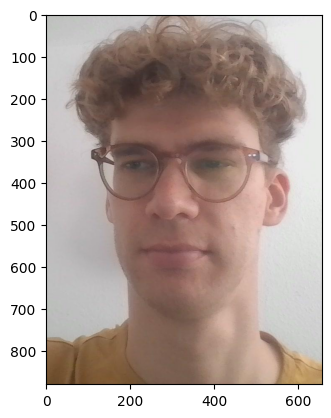

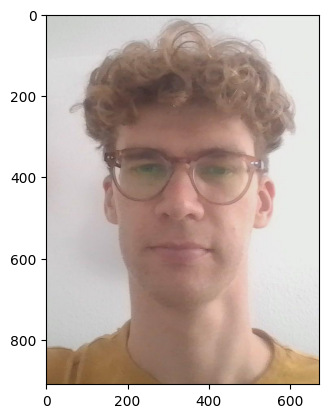

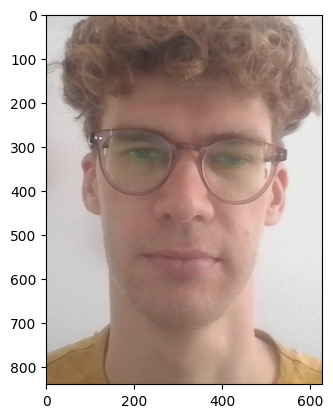

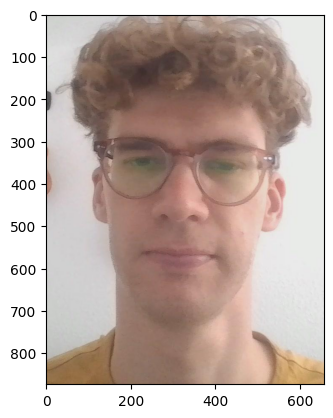

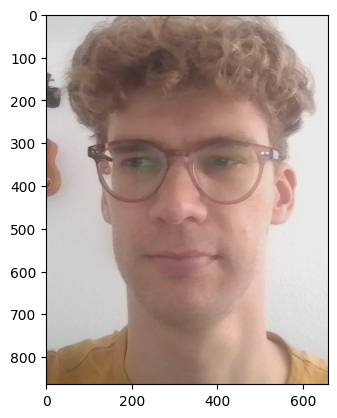

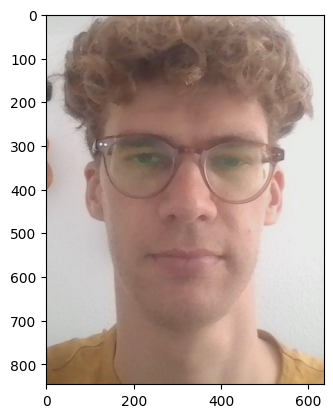

In [119]:
for img in my_face_images:
    with open(img, 'rb') as img_code:
        img_view_ready = Image.open(img_code)
        plt.figure()
        plt.imshow(img_view_ready)

# Create Person model

In [120]:
PERSON_GROUP_ID = str(uuid.uuid4())
person_group_name = 'person-johannes'

In [121]:
PERSON_GROUP_ID

'9e3e91e5-05a3-45f7-8f58-3ba197b5c263'

In [122]:
## This code is taken from Azure face SDK 
## ---------------------------------------
def build_person_group(client, person_group_id, pgp_name):
    print('Create and build a person group...')
    # Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
    print('Person group ID:', person_group_id)
    client.person_group.create(person_group_id = person_group_id, name=person_group_id, recognition_model='recognition_03')

    # Create a person group person.
    my_face = client.person_group_person.create(person_group_id, pgp_name)
    # Find all jpeg images of human in working directory.
    my_face_images = [file for file in glob.glob('./thumbnails/*.jpg')]
    # Add images to a Person object
    for image_p in my_face_images:
        with open(image_p, 'rb') as w:
            client.person_group_person.add_face_from_stream(person_group_id, my_face.person_id, w)

    # Train the person group, after a Person object with many images were added to it.
    client.person_group.train(person_group_id)

    # Wait for training to finish.
    while (True):
        training_status = client.person_group.get_training_status(person_group_id)
        print("Training status: {}.".format(training_status.status))
        if (training_status.status is TrainingStatusType.succeeded):
            break
        elif (training_status.status is TrainingStatusType.failed):
            client.person_group.delete(person_group_id=PERSON_GROUP_ID)
            sys.exit('Training the person group has failed.')
        time.sleep(5)


In [123]:
build_person_group(face_client, PERSON_GROUP_ID, person_group_name)

Create and build a person group...
Person group ID: 9e3e91e5-05a3-45f7-8f58-3ba197b5c263
Training status: TrainingStatusType.running.
Training status: TrainingStatusType.succeeded.


# Check if Face IDs are recognized correctly

In [125]:
'''
Detect all faces in query image list, then add their face IDs to a new list.
'''
def detect_faces(client, query_images_list):
    print('Detecting faces in query images list...')

    face_ids = {} # Keep track of the image ID and the related image in a dictionary
    for image_name in query_images_list:
        image = open(image_name, 'rb') # BufferedReader
        print("Opening image: ", image.name)
        time.sleep(5)

        # Detect the faces in the query images list one at a time, returns list[DetectedFace]
        faces = client.face.detect_with_stream(image, detection_model='detection_03', recognition_model='recognition_03')  

        # Add all detected face IDs to a list
        for face in faces:
            print('Face ID', face.face_id, 'found in image', os.path.splitext(image.name)[0]+'.jpg')
            # Add the ID to a dictionary with image name as a key.
            # This assumes there is only one face per image (since you can't have duplicate keys)
            face_ids[image.name] = face.face_id

    return face_ids

In [126]:
test_images = [file for file in glob.glob('./thumbnails/*.jpg')]

In [127]:
ids = detect_faces(face_client, test_images)

Detecting faces in query images list...
Opening image:  ./thumbnails\human-face1.jpg
Face ID 5947facd-f8d8-475f-953d-98acb32c969f found in image ./thumbnails\human-face1.jpg
Opening image:  ./thumbnails\human-face2.jpg
Face ID 025a16fb-77d2-4c6a-a4ab-b85da251ebef found in image ./thumbnails\human-face2.jpg
Opening image:  ./thumbnails\human-face3.jpg
Face ID 0ad2d830-61a2-4ae7-9676-96acd8036085 found in image ./thumbnails\human-face3.jpg
Opening image:  ./thumbnails\human-face4.jpg
Face ID 9dfce443-5f53-4dab-98b2-b71b67644970 found in image ./thumbnails\human-face4.jpg
Opening image:  ./thumbnails\human-face5.jpg
Face ID 571429fc-271f-4e4d-a6d6-aff0982e5d0b found in image ./thumbnails\human-face5.jpg
Opening image:  ./thumbnails\human-face6.jpg
Face ID 21d5b06a-4c4c-4016-80b1-a572c1ab8b85 found in image ./thumbnails\human-face6.jpg
Opening image:  ./thumbnails\human-face7.jpg
Face ID 9f50d107-b3bc-4494-8579-fe620f0d2734 found in image ./thumbnails\human-face7.jpg
Opening image:  ./thum

## Verify two faces from the folder are similar

In [128]:
ids

{'./thumbnails\\human-face1.jpg': '5947facd-f8d8-475f-953d-98acb32c969f',
 './thumbnails\\human-face2.jpg': '025a16fb-77d2-4c6a-a4ab-b85da251ebef',
 './thumbnails\\human-face3.jpg': '0ad2d830-61a2-4ae7-9676-96acd8036085',
 './thumbnails\\human-face4.jpg': '9dfce443-5f53-4dab-98b2-b71b67644970',
 './thumbnails\\human-face5.jpg': '571429fc-271f-4e4d-a6d6-aff0982e5d0b',
 './thumbnails\\human-face6.jpg': '21d5b06a-4c4c-4016-80b1-a572c1ab8b85',
 './thumbnails\\human-face7.jpg': '9f50d107-b3bc-4494-8579-fe620f0d2734',
 './thumbnails\\human-face8.jpg': '9f668246-4296-4d72-aa1f-6f4022438014'}

In [129]:
# Verification example for faces of the same person.
verify_result = face_client.face.verify_face_to_face(ids['./thumbnails\\human-face1.jpg'], ids['./thumbnails\\human-face2.jpg'])

In [130]:
if verify_result.is_identical:
    print("Faces are of the same (Positive) person, similarity confidence: {}.".format(verify_result.confidence))
else:
    print("Faces are of different (Negative) persons, similarity confidence: {}.".format(verify_result.confidence))

Faces are of the same (Positive) person, similarity confidence: 0.97162.


# Store Person Group ID to a text file on Blob Storage

In [131]:
keyVaultName = "cvprojectkeyvault"
KVUri = f"https://{keyVaultName}.vault.azure.net"

credential = DefaultAzureCredential()

In [132]:
account_url = "https://computervisionproject.blob.core.windows.net"
blob_service_client = BlobServiceClient(account_url, credential=credential)
container = 'kiosk'
blob_path = 'face_video/person_group_id.txt'
blob_client = blob_service_client.get_blob_client(container = container, blob = blob_path)

In [134]:
blob_client.upload_blob(PERSON_GROUP_ID, overwrite=True)

{'etag': '"0x8DC7CAF6390736F"',
 'last_modified': datetime.datetime(2024, 5, 25, 11, 39, 51, tzinfo=datetime.timezone.utc),
 'content_md5': bytearray(b'\x16Z\x8bk\xcb"\xd0u\xa6P\x1d\xfa\xb4\xbe\xa7\xfd'),
 'client_request_id': '7f6c8e9c-1a8b-11ef-847c-701ab80a14cc',
 'request_id': '335c52ef-901e-000e-4a98-ae4c7b000000',
 'version': '2024-05-04',
 'version_id': None,
 'date': datetime.datetime(2024, 5, 25, 11, 39, 50, tzinfo=datetime.timezone.utc),
 'request_server_encrypted': True,
 'encryption_key_sha256': None,
 'encryption_scope': None}

# Match with face from ID card (without Person Group)

In [135]:
def show_image_in_cell(img_path):
    img = Image.open(img_path)
    plt.figure(figsize=(10,5))
    plt.imshow(img)
    plt.show()

In [136]:
dl_image = open('../material_preparation_step/IDs/ca-dl-johannes_czylwik.png', 'rb')
dl_faces = face_client.face.detect_with_stream(dl_image, detection_model='detection_03', recognition_model='recognition_03')  

In [137]:
for face in dl_faces:
    print('Face ID', face.face_id, 'found in image ca-dl-johannes_czylwik.png')
    # Add the ID to a dictionary with image name as a key.
    # This assumes there is only one face per image (since you can't have duplicate keys)
    ids['ca-dl-johannes_czylwik.png'] = face.face_id

Face ID 25430b5a-967f-43cf-951d-b948941f8c09 found in image ca-dl-johannes_czylwik.png


The face ID detected in the image if the ID card is now added to our list of face IDs:

In [138]:
ids

{'./thumbnails\\human-face1.jpg': '5947facd-f8d8-475f-953d-98acb32c969f',
 './thumbnails\\human-face2.jpg': '025a16fb-77d2-4c6a-a4ab-b85da251ebef',
 './thumbnails\\human-face3.jpg': '0ad2d830-61a2-4ae7-9676-96acd8036085',
 './thumbnails\\human-face4.jpg': '9dfce443-5f53-4dab-98b2-b71b67644970',
 './thumbnails\\human-face5.jpg': '571429fc-271f-4e4d-a6d6-aff0982e5d0b',
 './thumbnails\\human-face6.jpg': '21d5b06a-4c4c-4016-80b1-a572c1ab8b85',
 './thumbnails\\human-face7.jpg': '9f50d107-b3bc-4494-8579-fe620f0d2734',
 './thumbnails\\human-face8.jpg': '9f668246-4296-4d72-aa1f-6f4022438014',
 'ca-dl-johannes_czylwik.png': '25430b5a-967f-43cf-951d-b948941f8c09'}

## Perform face verification

In [139]:
dl_verify_result = face_client.face.verify_face_to_face(ids['./thumbnails\\human-face5.jpg'], ids['ca-dl-johannes_czylwik.png'])

In [140]:
if dl_verify_result.is_identical:
    print("Faces are of the same (Positive) person, similarity confidence: {}.".format(dl_verify_result.confidence))
else:
    print("Faces are of different (Negative) persons, similarity confidence: {}.".format(dl_verify_result.confidence))

Faces are of the same (Positive) person, similarity confidence: 0.81206.


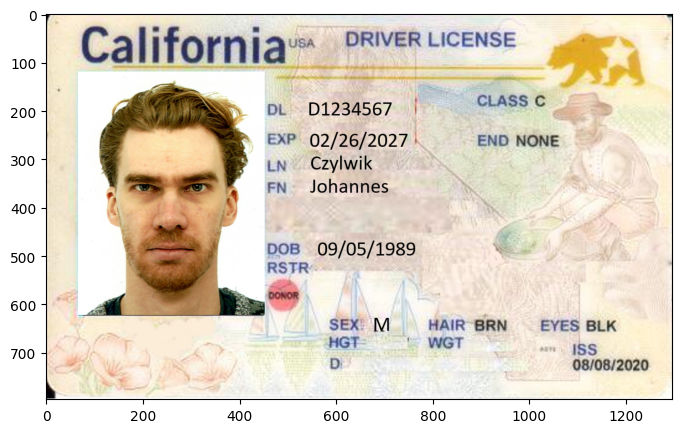

In [141]:
show_image_in_cell("../material_preparation_step/IDs/ca-dl-johannes_czylwik.png")

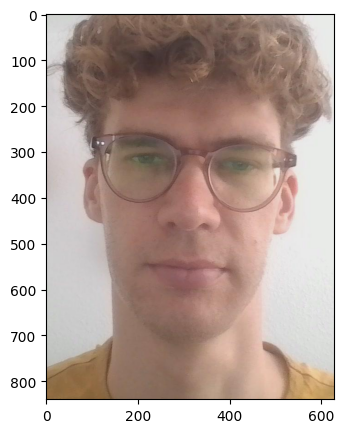

In [142]:
show_image_in_cell("thumbnails/human-face5.jpg")

The newer models `detection_03` and `recognition_03` were able to detect that those two pictures include the same face.  
It's not that easy since I do look quite different on those pictures and the one on the fake ID card is a few years older. :-)  
The default models `detection_01` and `recognition_01` didn't get it right. 

In [143]:
# TAKEN FROM THE Azure SDK Sample
# Convert width height to a point in a rectangle
def getRectangle(faceDictionary):
    rect = faceDictionary.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height
    
    return ((left, top), (right, bottom))

In [144]:
def drawFaceRectangles(source_file, detected_face_object) :
    img = Image.open(source_file)
    # Draw a red box around every detected faces
    draw = ImageDraw.Draw(img)
    for face in detected_face_object:
        draw.rectangle(getRectangle(face), outline='red', width = 10)
    return img

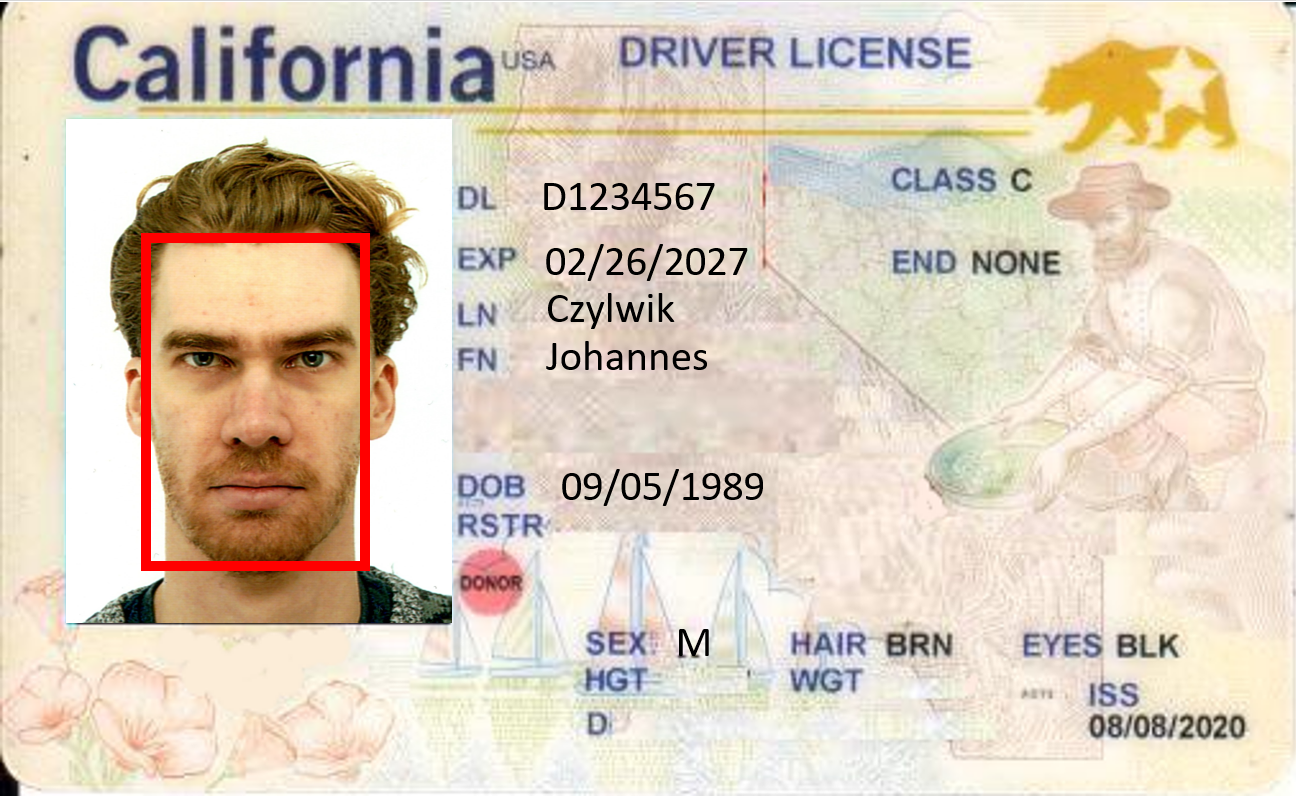

In [145]:
drawFaceRectangles("../material_preparation_step/IDs/ca-dl-johannes_czylwik.png", dl_faces)

# Matching Person Group with face from ID card

In [146]:
face_id_from_the_driving_license = ids['ca-dl-johannes_czylwik.png']

In [147]:
person_gp_results = face_client.face.identify([face_id_from_the_driving_license], PERSON_GROUP_ID)

In [148]:
for result in person_gp_results:
    for candidate in result.candidates:
        print("The Identity match confidence is {}".format(candidate.confidence))

The Identity match confidence is 0.81685


Match was Person Group was correct as well!